# Влияние условий жизни учащихся на академическую успеваемость по математике: эксплораторный анализ данных 

### Цель проекта

Целью данного проекта является исследование взаимосвязи между условиями жизни, уровнем благополучия учащихся в возрасте от 15 до 22 лет и их академическими успехами по математике. Анализ проводится с целью заблаговременного выявления учашихся, находящихся в потенциальной группе риска.

### Задача проекта

Глобальной задачей данного исследования является использование методов машинного обучения для построения модели, которая бы предсказывала результаты государственного экзамена по математике. Однако основной задачей данного проекта стоит именно проведение эксплораторного анализа данных с целью выявить наиболее релевантные переменные, которые будут включены в будущую модель.

В процессе анализа будут рассмотрены все переменные и их взаимосвязь с зависимой переменной - количеством баллов по математике.

In [1]:
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
ma = pd.read_csv('stud_math.xls')

### **Общие характеристики датасета**

Анализируемый датасет содержит **29** потенциальных предикторов для предсказания финального количества баллов, набранного учеником по математике (`score`). Всего датасет содержит **395** наблюдений, однако среди некоторых переменных присутствует небольшое количество пропущенных значений.

### **Анализ зависимой переменной (`score`)**

**Описательные статистики:**

In [3]:
ma_desc = pd.DataFrame({'Value': ma['score'].describe()})
ma_desc = ma_desc.reset_index().rename(columns={'index': 'Statistic'})
round(ma_desc, 1)

,Statistic,Value
0,count,389.0
1,mean,52.3
2,std,22.9
3,min,0.0
4,25%,40.0
5,50%,55.0
6,75%,70.0
7,max,100.0


Итак, первичные описательные статистики говорят о том, что диапазон оценок по математике варируется **от 0 до 100 баллов**, со средним значением **52 балла**, медианным - **55 баллов** и стандартным отклонением в **23 балла**. Большинство типичных значений попадает в диапазон от 40 до 70 баллов, что соответствует значению межквартильного размаха равному 30 баллам.

**Анализ выбросов:**

In [4]:
def check_outliers(var):
    quant25 = var.quantile(0.25)
    quant75 = var.quantile(0.75)
    IQR = quant75 - quant25
    outlier_below = quant25 - 1.5*IQR
    outlier_above = quant75 + 1.5*IQR
    outlier_range = pd.DataFrame(
        [{'lower_bound': outlier_below, 'upper_bound': outlier_above}])
    return outlier_range


check_outliers(ma['score'])

,lower_bound,upper_bound
0,-5.0,115.0


Поскольку все значения переменной `score` находятся в диапазоне от 0 до 100 (как было показано ранее), можем сказать, что выбросов не обнаружено. 

Однако стоит отметить, что нулевой балл по математике - это, скорее всего, техническая запись в данных, означающая, что ученика по каким-либо причинам не было на экзамене (всего таких записей обнаружено 37), поскольку с практической точки зрения вероятность получить оценку "0 баллов" очень мала. 

В ходе дальнейшего анализа наблюдения со значением 0 в переменной `score` рассматриваться не будут.

In [5]:
len(ma.score[ma.score == 0])

37

In [6]:
ma = ma[ma.score != 0]

**Распределение зависимой переменной `score`:**

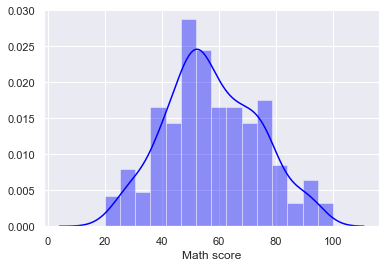

In [7]:
sns.set()
pl = sns.distplot(ma['score'], kde_kws={'clip': (
    0, 100)}, bins=15, color='blue', axlabel='Math score')

По графику распределения баллов по математике видно, что большинство значений находятся в диапазоне от 40 до 70 баллов, что и было показано в разделе "Описальные статистики". Также стоит отметить, что распределение близко к нормальному.

### **Анализ пропущенных значений в датасете:**

In [8]:
miss = pd.DataFrame({'Missings': ma.isna().sum()})
miss = miss.reset_index().rename(columns={'index': 'Variable'})
display(miss)

,Variable,Missings
0,school,0
1,sex,0
2,age,0
3,address,16
4,famsize,24
5,Pstatus,41
6,Medu,2
7,Fedu,21
8,Mjob,17
9,Fjob,32


Как можно заметить, наибольшее количество пропущенных значений имеет переменная "Статус совместного проживания родителей" (41), в то время как некоторые переменные имеют лишь незначительное количество пропусков.

Что касается зависимой переменной (`score`), она имеет **6** пропущенных значений, которые имеет смысл удалить из датасета для дальнейшего анализа. 

В итоге остается датасет с **352** наблюдениями.

In [9]:
ma = ma.dropna(axis=0, subset=['score'])
len(ma)

352

Для дальнейшей продуктивной работы с переменной `score`, в частности, для наглядности взаимосвязи между таргет-переменной и категориальными предикторами, содадим новую переменную `score_cut` c помощью следующего преобразования: разобьем исходную переменную `score` на осмысленные диапазоны, то есть преобразуем количественную переменную в категориальную.

In [10]:
ma['score_cut'] = pd.cut(ma.score, 4)

In [11]:
score_cut_table = pd.DataFrame(
    round(ma.score_cut.value_counts(normalize=True)*100, 1))
score_cut_table = score_cut_table.reset_index().rename(
    columns={'score_cut': 'perc', 'index': 'score_cut'})
score_cut_table.score_cut = score_cut_table.score_cut.astype('str')
score_cut_table

,score_cut,perc
0,"(40.0, 60.0]",44.9
1,"(60.0, 80.0]",30.4
2,"(19.92, 40.0]",17.9
3,"(80.0, 100.0]",6.8


Text(0.5, 0, 'Диапазон баллов')

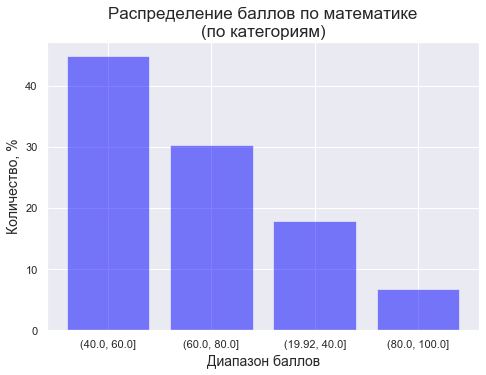

In [12]:
fig = plt.figure()
main = fig.add_axes([0, 0, 1, 1])
main.bar(x=score_cut_table['score_cut'],
         height=score_cut_table['perc'], color='blue', alpha=0.5)
main.set_title('Распределение баллов по математике\n(по категориям)', size=17)
main.set_ylabel('Количество, %', size=14)
main.set_xlabel('Диапазон баллов', size=14)

# Как отсортировать по столбцам в логическом порядке занчений ОХ
# Как добавить подписи значений на столбцах без функций

## Анализ независимых переменных

### **Школа**

**Анализ пропущенных значений:**

In [13]:
def remove_na(var):
    global new_df
    new_df = ma.dropna(axis=0, subset=[var])
    print('There were', ma[var].isna().sum(),
          'missings that have been removed')


remove_na('school')

There were 0 missings that have been removed


**Анализ значений переменной:**

In [14]:
def get_stats(var):
    stats = round(pd.DataFrame({'Value': var.describe(include=['object'])}), 1)
    stats = stats.reset_index().rename(columns={'index': 'Statistic'})
    round(stats, 1)
    print('There are', var.nunique(), 'unique values in this variable:', var.unique(),
          '\nCounts:', pd.DataFrame(var.value_counts()), '\nAdditional info:')
    return stats


get_stats(new_df['school'])

There are 2 unique values in this variable: ['GP' 'MS'] 
Counts:     school
GP     311
MS      41 
Additional info:


,Statistic,Value
0,count,352
1,unique,2
2,top,GP
3,freq,311


Как видно из краткого анализа переменной, а данных представлено только 2 школы, причем большинство учеников (более 85 %) принадлежат школе GP.

**Подготовка данных и визуализация взаимосвязи:**

In [82]:
def get_table(var):
    vis = round(pd.DataFrame({'perc': new_df[[var, 'score_cut']].groupby(var)['score_cut'].
                              value_counts(normalize=True)}), 2)*100
    return(vis)


get_table('school')

# нужно, чтобы название школы дублировалось и колонки были различимы - так и не получилось разобраться.

perc
school score_cut          
GP     (40.0, 60.0]   44.0
       (60.0, 80.0]   31.0
       (19.92, 40.0]  18.0
       (80.0, 100.0]   7.0
MS     (40.0, 60.0]   51.0
       (60.0, 80.0]   27.0
       (19.92, 40.0]  20.0
       (80.0, 100.0]   2.0

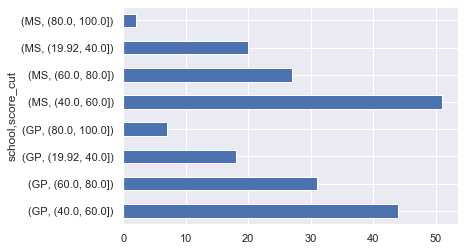

In [83]:
def make_plot(var):
    plot = get_table(var).plot.barh(legend=False)
    return plot


make_plot('school')

Из графика видно, что в школе GP процент учащихся, набирающих самые большие баллых - выше, чем в MS. Однако разница не очень существенная.

Таким образом, переменную скорее всего не стоит добавлять в финальную модель в качестве предиктора.

### **Пол ученика**

**Анализ пропущенных значений:**

In [79]:
remove_na('sex')

There were 0 missings that have been removed


**Анализ значений переменной:**

In [84]:
get_stats(new_df['sex'])

There are 2 unique values in this variable: ['F' 'M'] 
Counts:    sex
F  182
M  170 
Additional info:


,Statistic,Value
0,count,352
1,unique,2
2,top,F
3,freq,182


Как можно заметить, как мальчики, так и девочки представлены в данных почти в равном количестве, с небольшим перевесом в сторону мужского пола.

**Подготовка данных и визуализация взаимосвязи:**

In [85]:
get_table('sex')

perc
sex score_cut          
F   (40.0, 60.0]   46.0
    (60.0, 80.0]   29.0
    (19.92, 40.0]  19.0
    (80.0, 100.0]   5.0
M   (40.0, 60.0]   44.0
    (60.0, 80.0]   32.0
    (19.92, 40.0]  16.0
    (80.0, 100.0]   8.0

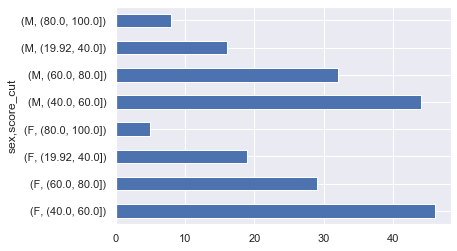

In [86]:
make_plot('sex')

Из графика видно, что мальчики, в среднем, получают более высокие баллы по математике. Почти вдвое больше мальчиков (чем девочек) получили наивысшие баллы (от 80 до 100).

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Возраст ученика**

**Анализ пропущенных значений:**

In [87]:
remove_na('age')

There were 0 missings that have been removed


**Анализ значений переменной:**

In [88]:
get_stats(new_df['age'])

There are 8 unique values in this variable: [18 17 15 16 19 22 20 21] 
Counts:     age
16   96
17   90
15   76
18   69
19   16
20    3
22    1
21    1 
Additional info:


,Statistic,Value
0,count,352.0
1,mean,16.6
2,std,1.3
3,min,15.0
4,25%,16.0
5,50%,17.0
6,75%,18.0
7,max,22.0


Как и заявлено в описании, возраст учащихся варируется от 15 до 22 лет, однако большинство типичных значений лежит в диапазоне от 16 до 18 лет. Стоит отметить, что учеников в возрасте от 20 до 22 лет всего 4 человека во всем датасете.

**Анализ выбросов:**

In [89]:
check_outliers(new_df['age'])

,lower_bound,upper_bound
0,13.0,21.0


Наблюдение, с возрастом 22 являлось бы выбросом, но поскольку в описании данных заявлен возрастной дианазон от 15 до 22 лет - не будет его удалять.

**Подготовка данных и визуализация взаимосвязи:**

In [90]:
get_table('age')

perc
age score_cut           
15  (40.0, 60.0]    41.0
    (60.0, 80.0]    33.0
    (19.92, 40.0]   16.0
    (80.0, 100.0]   11.0
16  (40.0, 60.0]    44.0
    (60.0, 80.0]    35.0
    (19.92, 40.0]   15.0
    (80.0, 100.0]    6.0
17  (40.0, 60.0]    50.0
    (60.0, 80.0]    28.0
    (19.92, 40.0]   18.0
    (80.0, 100.0]    4.0
18  (40.0, 60.0]    43.0
    (60.0, 80.0]    26.0
    (19.92, 40.0]   23.0
    (80.0, 100.0]    7.0
19  (40.0, 60.0]    56.0
    (60.0, 80.0]    25.0
    (19.92, 40.0]   19.0
20  (40.0, 60.0]    33.0
    (60.0, 80.0]    33.0
    (80.0, 100.0]   33.0
21  (19.92, 40.0]  100.0
22  (19.92, 40.0]  100.0

Из таблицы видно, что в 15 лет около 11% учеников получили наивысшие результаты по математике, однако после этого учеников с такими показателями становилось все меньше и меньше. Отчетливую взаимосвязь отмледить сложно.

Таким образом, переменную скорее не стоит добавлять в финальную модель в качестве предиктора.

### **Тип местности проживания**

**Анализ пропущенных значений:**

In [92]:
remove_na('address')

There were 14 missings that have been removed


**Анализ значений переменной:**

In [93]:
get_stats(new_df['address'])

There are 2 unique values in this variable: ['U' 'R'] 
Counts:    address
U      265
R       73 
Additional info:


,Statistic,Value
0,count,338
1,unique,2
2,top,U
3,freq,265


Большинство (около 80 %) учащихся проживают в городской местности (*Urban*), в то время как около 20 % - в сельской (*Rural*).

**Подготовка данных и визуализация взаимосвязи:**

In [94]:
get_table('address')

perc
address score_cut          
R       (40.0, 60.0]   48.0
        (19.92, 40.0]  26.0
        (60.0, 80.0]   21.0
        (80.0, 100.0]   5.0
U       (40.0, 60.0]   43.0
        (60.0, 80.0]   33.0
        (19.92, 40.0]  16.0
        (80.0, 100.0]   8.0

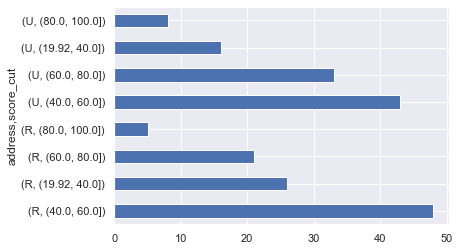

In [95]:
make_plot('address')

Из графика видно, что ученики из сельской местности учатся, в среднем, лучше, чем ученики из городов. Разница видна как в наивысших, так и наименьших оценках.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Размер семьи**

**Анализ пропущенных значений:**

In [96]:
remove_na('famsize')

There were 24 missings that have been removed


**Анализ значений переменной:**

In [97]:
get_stats(new_df['famsize'])

There are 2 unique values in this variable: ['GT3' 'LE3'] 
Counts:      famsize
GT3      228
LE3      100 
Additional info:


,Statistic,Value
0,count,328
1,unique,2
2,top,GT3
3,freq,228


Большинство учеников (около 70 %) живут в семьях, где количество ее членов превышает 3 человека, остальные 30 % - в семьях, не превышаюших эту отметку.

**Подготовка данных и визуализация взаимосвязи:**

In [98]:
get_table('famsize')

perc
famsize score_cut          
GT3     (40.0, 60.0]   44.0
        (60.0, 80.0]   31.0
        (19.92, 40.0]  18.0
        (80.0, 100.0]   7.0
LE3     (40.0, 60.0]   46.0
        (60.0, 80.0]   31.0
        (19.92, 40.0]  16.0
        (80.0, 100.0]   7.0

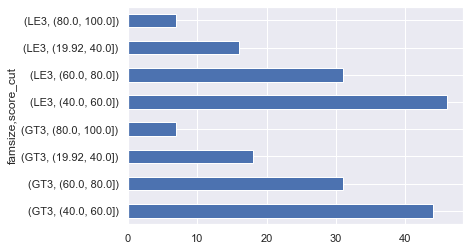

In [100]:
make_plot('famsize')

Из графика видно, что существенную разницу между учениками из семей с количеством членов больше и меньше трех отследить сложно. Примерно равные пропорции ученико получают наивысшие и наименьшие баллы по математике.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Статус совместного сожительства родителей**

**Анализ пропущенных значений:**

In [101]:
remove_na('Pstatus')

There were 41 missings that have been removed


**Анализ значений переменной:**

In [102]:
get_stats(new_df['Pstatus'])

There are 2 unique values in this variable: ['A' 'T'] 
Counts:    Pstatus
T      277
A       34 
Additional info:


,Statistic,Value
0,count,311
1,unique,2
2,top,T
3,freq,277


Большинство родителей учеников живут вместе (90%), однако некоторая часть (10%) состоят в разводе\живут отдельно друг от друга.

**Подготовка данных и визуализация взаимосвязи:**

In [103]:
get_table('Pstatus')

perc
Pstatus score_cut          
A       (40.0, 60.0]   47.0
        (60.0, 80.0]   24.0
        (19.92, 40.0]  18.0
        (80.0, 100.0]  12.0
T       (40.0, 60.0]   45.0
        (60.0, 80.0]   32.0
        (19.92, 40.0]  18.0
        (80.0, 100.0]   5.0

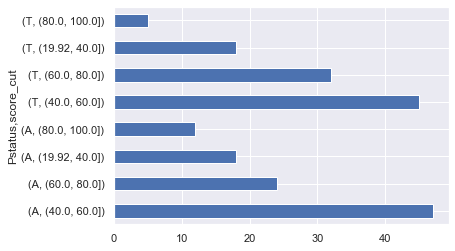

In [104]:
make_plot('Pstatus')

Из графика видно, что ученики, чьи родители не живут вместе (**A**part) в среднем учаться лучше, чем те, у кого родители живут вместе. Почти вдвое больше учеников из неполных семей (по сравнению с теми, чьи родители живут вместе (**T**ogather)) получают наивысшие оценки по математике.

Таким образом, переменную определенно стоит оставить для добавления в финальную модель в качестве предиктора.

### **Oбразование матери**

**Анализ пропущенных значений:**

In [105]:
remove_na('Medu')

There were 2 missings that have been removed


**Анализ значений переменной:**

In [106]:
new_df.Medu = new_df.Medu.astype('str')
get_stats(new_df['Medu'])

There are 5 unique values in this variable: ['4.0' '1.0' '3.0' '2.0' '0.0'] 
Counts:      Medu
4.0   125
2.0    88
3.0    87
1.0    47
0.0     3 
Additional info:


,Statistic,Value
0,count,350
1,unique,5
2,top,4.0
3,freq,125


Более 35% матерей имеют высшее образование, ещё по 25% - имеют среднее специальное или закончили 11 классов школы/закончили 5-9 классов. Около 13% матерей закончили только 4 класса, и лишь у 3 матерей нет образования совсем.

**Подготовка данных и визуализация взаимосвязи:**

In [107]:
get_table('Medu')

perc
Medu score_cut          
0.0  (60.0, 80.0]   67.0
     (40.0, 60.0]   33.0
1.0  (40.0, 60.0]   60.0
     (19.92, 40.0]  23.0
     (60.0, 80.0]   17.0
2.0  (40.0, 60.0]   50.0
     (60.0, 80.0]   27.0
     (19.92, 40.0]  18.0
     (80.0, 100.0]   5.0
3.0  (40.0, 60.0]   46.0
     (60.0, 80.0]   25.0
     (19.92, 40.0]  20.0
     (80.0, 100.0]   9.0
4.0  (60.0, 80.0]   41.0
     (40.0, 60.0]   35.0
     (19.92, 40.0]  14.0
     (80.0, 100.0]  10.0

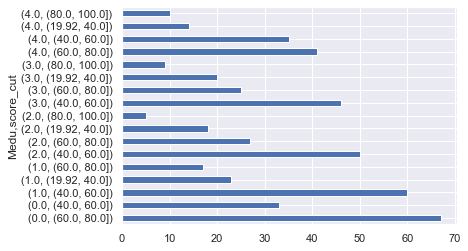

In [108]:
make_plot('Medu')

Из графика видно, что ученики, чьи матери имеют высшее или хотя бы среднее специальное образование учатся существенно лучше. Ученики, матери которых не имеют достаточного образования (несколько классов школы) практически не фигурируют среди учеников, получающих наивысшие оценки по математике.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Oбразование отца**

**Анализ пропущенных значений:**

In [109]:
remove_na('Fedu')

There were 21 missings that have been removed


**Анализ значений переменной:**

In [110]:
new_df.Fedu = new_df.Fedu.astype('str')
get_stats(new_df['Fedu'])

There are 6 unique values in this variable: ['4.0' '1.0' '2.0' '3.0' '40.0' '0.0'] 
Counts:       Fedu
2.0     94
3.0     89
4.0     80
1.0     65
0.0      2
40.0     1 
Additional info:


,Statistic,Value
0,count,331
1,unique,6
2,top,2.0
3,freq,94


Видна опечатка в данных, исправим ее:

In [111]:
new_df['Fedu'] = new_df['Fedu'].replace(['40.0'], '4.0')

In [112]:
get_stats(new_df['Fedu'])

There are 5 unique values in this variable: ['4.0' '1.0' '2.0' '3.0' '0.0'] 
Counts:      Fedu
2.0    94
3.0    89
4.0    81
1.0    65
0.0     2 
Additional info:


,Statistic,Value
0,count,331
1,unique,5
2,top,2.0
3,freq,94


Около 25% отцов имеют высшее образование, около 27% - имеют среднее специальное или закончили 11 классов школы, 28% - закончили 5-9 классов. Около 20% отцов закончили только 4 класса, и лишь у 2 отцов нет образования совсем.

**Подготовка данных и визуализация взаимосвязи:**

In [113]:
get_table('Fedu')

perc
Fedu score_cut          
0.0  (40.0, 60.0]   50.0
     (60.0, 80.0]   50.0
1.0  (40.0, 60.0]   49.0
     (19.92, 40.0]  25.0
     (60.0, 80.0]   23.0
     (80.0, 100.0]   3.0
2.0  (40.0, 60.0]   47.0
     (60.0, 80.0]   33.0
     (19.92, 40.0]  16.0
     (80.0, 100.0]   4.0
3.0  (40.0, 60.0]   46.0
     (60.0, 80.0]   27.0
     (19.92, 40.0]  19.0
     (80.0, 100.0]   8.0
4.0  (40.0, 60.0]   38.0
     (60.0, 80.0]   38.0
     (19.92, 40.0]  14.0
     (80.0, 100.0]  10.0

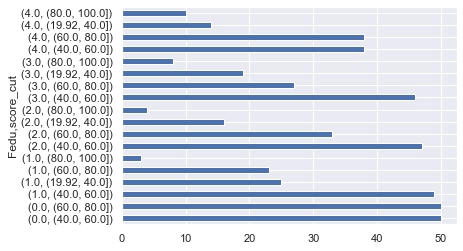

In [114]:
make_plot('Fedu')

Из графика видно, что образование отца влияет на успеваемость по математике похожим образом, что и образование матери. Для дальнейшего анализа имеет смысл объединить эти переменных, поскольку для более получения более информативной метрики.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Pабота матери**

**Анализ пропущенных значений:**

In [115]:
remove_na('Mjob')

There were 17 missings that have been removed


**Анализ значений переменной:**

In [116]:
get_stats(new_df['Mjob'])

There are 5 unique values in this variable: ['at_home' 'health' 'other' 'services' 'teacher'] 
Counts:           Mjob
other      115
services    90
teacher     51
at_home     49
health      30 
Additional info:


,Statistic,Value
0,count,335
1,unique,5
2,top,other
3,freq,115


Большинство матерей работают в сфере обслживания или других секторах рынка.

**Подготовка данных и визуализация взаимосвязи:**

In [117]:
get_table('Mjob')

perc
Mjob     score_cut          
at_home  (40.0, 60.0]   51.0
         (60.0, 80.0]   29.0
         (19.92, 40.0]  18.0
         (80.0, 100.0]   2.0
health   (60.0, 80.0]   53.0
         (40.0, 60.0]   30.0
         (19.92, 40.0]  10.0
         (80.0, 100.0]   7.0
other    (40.0, 60.0]   46.0
         (60.0, 80.0]   29.0
         (19.92, 40.0]  23.0
         (80.0, 100.0]   2.0
services (40.0, 60.0]   44.0
         (60.0, 80.0]   24.0
         (19.92, 40.0]  18.0
         (80.0, 100.0]  13.0
teacher  (40.0, 60.0]   45.0
         (60.0, 80.0]   33.0
         (19.92, 40.0]  14.0
         (80.0, 100.0]   8.0

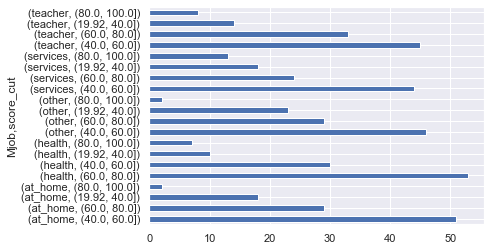

In [118]:
make_plot('Mjob')

Из графика видно, что наивысшие баллы по математике получают ученики, мамы которых имеют педагогическое образование (учителя) или же работают в сервисной сфере, в то время как занятость матерей в других сферах с точки зрения статистики не способствует академическому успеху по математике.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Pабота отца**

**Анализ пропущенных значений:**

In [119]:
remove_na('Fjob')

There were 32 missings that have been removed


**Анализ значений переменной:**

In [120]:
get_stats(new_df['Fjob'])

There are 5 unique values in this variable: ['teacher' 'other' 'health' 'services' 'at_home'] 
Counts:           Fjob
other      176
services    89
teacher     26
health      15
at_home     14 
Additional info:


,Statistic,Value
0,count,320
1,unique,5
2,top,other
3,freq,176


Большинство отцов также работают в сфере обслживания или других секторах рынка.

**Подготовка данных и визуализация взаимосвязи:**

In [121]:
get_table('Fjob')

perc
Fjob     score_cut          
at_home  (40.0, 60.0]   43.0
         (60.0, 80.0]   36.0
         (19.92, 40.0]  14.0
         (80.0, 100.0]   7.0
health   (60.0, 80.0]   40.0
         (40.0, 60.0]   33.0
         (19.92, 40.0]  27.0
other    (40.0, 60.0]   47.0
         (60.0, 80.0]   30.0
         (19.92, 40.0]  19.0
         (80.0, 100.0]   5.0
services (40.0, 60.0]   54.0
         (60.0, 80.0]   28.0
         (19.92, 40.0]  16.0
         (80.0, 100.0]   2.0
teacher  (60.0, 80.0]   35.0
         (40.0, 60.0]   31.0
         (80.0, 100.0]  23.0
         (19.92, 40.0]  12.0

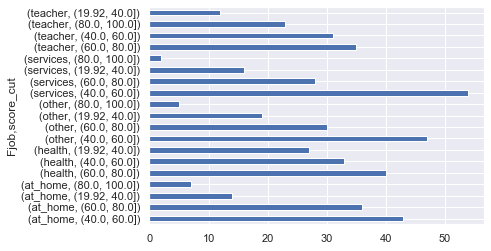

In [122]:
make_plot('Fjob')

Из графика видно, что паттерн взаимосвязи между переменными отличен от схожей ситуации с работой матери: более 20 % учеников, чьи папы заняты в сфере педагогики, получают наивысшие баллы по математике, однако занятость в сервисной сфере не показывает такого же резльтата.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Причина выбора школы**

**Анализ пропущенных значений:**

In [123]:
remove_na('reason')

There were 15 missings that have been removed


**Анализ значений переменной:**

In [124]:
get_stats(new_df['reason'])

There are 4 unique values in this variable: ['course' 'other' 'home' 'reputation'] 
Counts:             reason
course         119
reputation      96
home            89
other           33 
Additional info:


,Statistic,Value
0,count,337
1,unique,4
2,top,course
3,freq,119


Большинство родителей выбирали школы для своих детей основываясь на представленных ученых программах, а также на репутации школы.

**Подготовка данных и визуализация взаимосвязи:**

In [125]:
get_table('reason')

perc
reason     score_cut          
course     (40.0, 60.0]   48.0
           (60.0, 80.0]   26.0
           (19.92, 40.0]  20.0
           (80.0, 100.0]   6.0
home       (40.0, 60.0]   46.0
           (60.0, 80.0]   30.0
           (19.92, 40.0]  17.0
           (80.0, 100.0]   7.0
other      (40.0, 60.0]   36.0
           (60.0, 80.0]   33.0
           (19.92, 40.0]  21.0
           (80.0, 100.0]   9.0
reputation (40.0, 60.0]   41.0
           (60.0, 80.0]   34.0
           (19.92, 40.0]  17.0
           (80.0, 100.0]   8.0

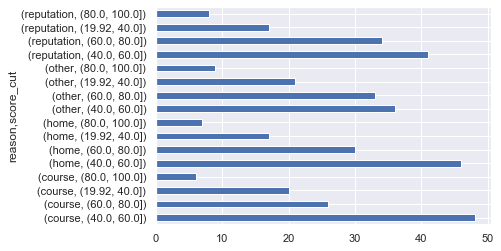

In [126]:
make_plot('reason')

Из графика видно, что распределения диапазона оценок довольно схожи исходя из информации о причинах выбора школы.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Опекун**

**Анализ пропущенных значений:**

In [127]:
remove_na('guardian')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [128]:
get_stats(new_df['guardian'])

There are 3 unique values in this variable: ['mother' 'father' 'other'] 
Counts:         guardian
mother       225
father        78
other         20 
Additional info:


,Statistic,Value
0,count,323
1,unique,3
2,top,mother
3,freq,225


**Подготовка данных и визуализация взаимосвязи:**

In [129]:
get_table('guardian')

perc
guardian score_cut          
father   (40.0, 60.0]   47.0
         (60.0, 80.0]   32.0
         (19.92, 40.0]  13.0
         (80.0, 100.0]   8.0
mother   (40.0, 60.0]   42.0
         (60.0, 80.0]   31.0
         (19.92, 40.0]  20.0
         (80.0, 100.0]   8.0
other    (40.0, 60.0]   45.0
         (19.92, 40.0]  25.0
         (60.0, 80.0]   25.0
         (80.0, 100.0]   5.0

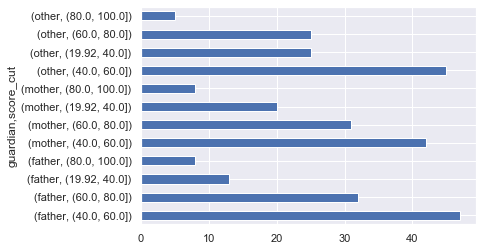

In [130]:
make_plot('guardian')

Довольно сложно оценить какаие-то отличиетльные особенности среди распределений оценок в зависимости от вида опекунства.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Время в пути до школы**

**Анализ пропущенных значений:**

In [131]:
remove_na('traveltime')

There were 23 missings that have been removed


**Анализ значений переменной:**

In [132]:
new_df.traveltime = new_df.traveltime.astype('str')
get_stats(new_df['traveltime'])

There are 4 unique values in this variable: ['2.0' '1.0' '3.0' '4.0'] 
Counts:      traveltime
1.0         219
2.0          86
3.0          17
4.0           7 
Additional info:


,Statistic,Value
0,count,329
1,unique,4
2,top,1.0
3,freq,219


Большинство учеников тратят <15 мин., чтобы добраться до школы. Некоторые тратят 15-30 мин., ещё меньшее количество - 30-60 мин., и лишь 7 человек тратят >60 мин.

**Подготовка данных и визуализация взаимосвязи:**

In [133]:
get_table('traveltime')

perc
traveltime score_cut          
1.0        (40.0, 60.0]   42.0
           (60.0, 80.0]   33.0
           (19.92, 40.0]  17.0
           (80.0, 100.0]   7.0
2.0        (40.0, 60.0]   49.0
           (60.0, 80.0]   27.0
           (19.92, 40.0]  19.0
           (80.0, 100.0]   6.0
3.0        (40.0, 60.0]   47.0
           (60.0, 80.0]   29.0
           (19.92, 40.0]  18.0
           (80.0, 100.0]   6.0
4.0        (40.0, 60.0]   71.0
           (19.92, 40.0]  14.0
           (60.0, 80.0]   14.0

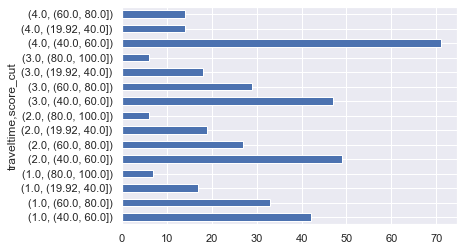

In [134]:
make_plot('traveltime')

Аналогично, паттерн распределения диапазонов оценок довольно схожий среди разных категорий по количеству времени, которое ученики тратят, чтобы добраться до школы. В основном, в каждой категории наблюдается схожее распределение, что и в общей совокупности.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Время на учёбу помимо школы в неделю**

**Анализ пропущенных значений:**

In [135]:
remove_na('studytime')

There were 7 missings that have been removed


**Анализ значений переменной:**

In [136]:
new_df.studytime = new_df.studytime.astype('str')
get_stats(new_df['studytime'])

There are 4 unique values in this variable: ['2.0' '3.0' '1.0' '4.0'] 
Counts:      studytime
2.0        173
1.0         90
3.0         58
4.0         24 
Additional info:


,Statistic,Value
0,count,345
1,unique,4
2,top,2.0
3,freq,173


Около четверти учеников тратят <2 часов для занятий учебой помимо школы в неделю, около 50% - 2-5 часов, ещё 17% - 5-10 часов, и около 7% >10 часов в неделю.

**Подготовка данных и визуализация взаимосвязи:**

In [137]:
get_table('studytime')

perc
studytime score_cut          
1.0       (40.0, 60.0]   42.0
          (60.0, 80.0]   30.0
          (19.92, 40.0]  22.0
          (80.0, 100.0]   6.0
2.0       (40.0, 60.0]   48.0
          (60.0, 80.0]   27.0
          (19.92, 40.0]  20.0
          (80.0, 100.0]   5.0
3.0       (40.0, 60.0]   45.0
          (60.0, 80.0]   40.0
          (80.0, 100.0]   9.0
          (19.92, 40.0]   7.0
4.0       (40.0, 60.0]   33.0
          (60.0, 80.0]   33.0
          (19.92, 40.0]  17.0
          (80.0, 100.0]  17.0

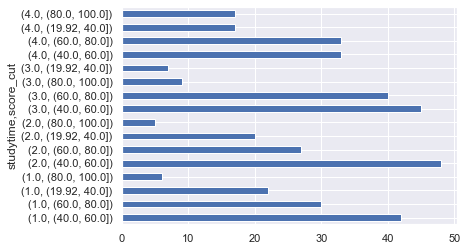

In [138]:
make_plot('studytime')

Из графика очевидно, что чем больше ученики тратят время на подготовку домашнего задания и самостоятельное обучение, тем выше, в среднем, их балл по математике. Например, более 15% учеников, кто тартит более 10 часов в неделю на учебы вне школы, получают наивысшие баллы по математике.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Дополнительная образовательная поддержка**

**Анализ пропущенных значений:**

In [139]:
remove_na('schoolsup')

There were 9 missings that have been removed


**Анализ значений переменной:**

In [140]:
get_stats(new_df['schoolsup'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      schoolsup
no         295
yes         48 
Additional info:


,Statistic,Value
0,count,343
1,unique,2
2,top,no
3,freq,295


Дополнительную образовательную поддержку от школу получают около 1/7 учеников школы.

**Подготовка данных и визуализация взаимосвязи:**

In [141]:
get_table('schoolsup')

perc
schoolsup score_cut          
no        (40.0, 60.0]   43.0
          (60.0, 80.0]   34.0
          (19.92, 40.0]  15.0
          (80.0, 100.0]   8.0
yes       (40.0, 60.0]   56.0
          (19.92, 40.0]  33.0
          (60.0, 80.0]    8.0
          (80.0, 100.0]   2.0

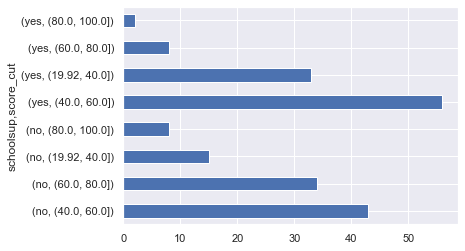

In [143]:
make_plot('schoolsup')

Из графика видно, что школьную поддержку получают, вероятнее всего, отстающие ученики или ученики с особенностями развития, поскольку те, кто поддержки НЕ получает, учатся, в среднем, лучше. 

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Семейная образовательная поддержка**

**Анализ пропущенных значений:**

In [144]:
remove_na('famsup')

There were 36 missings that have been removed


**Анализ значений переменной:**

In [145]:
get_stats(new_df['famsup'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      famsup
yes     196
no      120 
Additional info:


,Statistic,Value
0,count,316
1,unique,2
2,top,yes
3,freq,196


Дополнительную образовательную поддержку в семье получают около 2/3 учеников школы.

**Подготовка данных и визуализация взаимосвязи:**

In [146]:
get_table('famsup')

perc
famsup score_cut          
no     (40.0, 60.0]   45.0
       (60.0, 80.0]   32.0
       (19.92, 40.0]  16.0
       (80.0, 100.0]   7.0
yes    (40.0, 60.0]   43.0
       (60.0, 80.0]   28.0
       (19.92, 40.0]  21.0
       (80.0, 100.0]   8.0

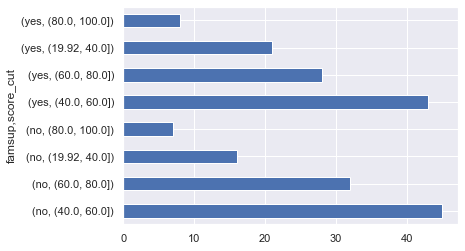

In [147]:
make_plot('famsup')

Из графика видно, что поддержка семьи в образовательном плане не сильно сказывается на академических успехах по математике, по сравнению с учениками, кто такой поддержки не получает.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Дополнительные платные занятия по математике**

**Анализ пропущенных значений:**

In [148]:
remove_na('paid')

There were 36 missings that have been removed


**Анализ значений переменной:**

In [149]:
get_stats(new_df['paid'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      paid
no    170
yes   146 
Additional info:


,Statistic,Value
0,count,316
1,unique,2
2,top,no
3,freq,170


Дополнительными платными занятиями по математике занимаются около 45% учеников школы.

**Подготовка данных и визуализация взаимосвязи:**

In [150]:
get_table('paid')

perc
paid score_cut          
no   (40.0, 60.0]   45.0
     (60.0, 80.0]   29.0
     (19.92, 40.0]  17.0
     (80.0, 100.0]   8.0
yes  (40.0, 60.0]   45.0
     (60.0, 80.0]   32.0
     (19.92, 40.0]  18.0
     (80.0, 100.0]   5.0

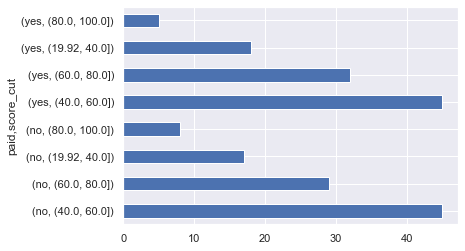

In [151]:
make_plot('paid')

Как бы удивительно ни было, ученики, которые не посещяют платные занятия с репетитором по математике в среднем чаще получают наивысшие баллы по предмету. В остальном, распределения практически идентичны.

Таким образом, переменную скорее не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Дополнительные внеучебные занятия**

**Анализ пропущенных значений:**

In [152]:
remove_na('activities')

There were 12 missings that have been removed


**Анализ значений переменной:**

In [153]:
get_stats(new_df['activities'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      activities
yes         172
no          168 
Additional info:


,Statistic,Value
0,count,340
1,unique,2
2,top,yes
3,freq,172


Дополнительными внеучебными занятиями занимаются около половины учеников школы.

**Подготовка данных и визуализация взаимосвязи:**

In [154]:
get_table('activities')

perc
activities score_cut          
no         (40.0, 60.0]   42.0
           (60.0, 80.0]   30.0
           (19.92, 40.0]  21.0
           (80.0, 100.0]   6.0
yes        (40.0, 60.0]   47.0
           (60.0, 80.0]   30.0
           (19.92, 40.0]  15.0
           (80.0, 100.0]   8.0

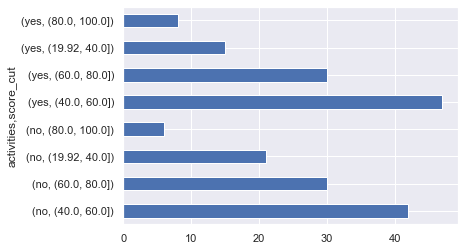

In [155]:
make_plot('activities')

Из графика видно, что ученики, посещающие кружки или хобби по интересам вне учебных занятий, в среднем учаться немного лучше, чем те, кто занятий не посещает.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Посещал ли ученик детский сад**

**Анализ пропущенных значений:**

In [156]:
remove_na('nursery')

There were 12 missings that have been removed


**Анализ значений переменной:**

In [157]:
get_stats(new_df['nursery'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      nursery
yes      272
no        68 
Additional info:


,Statistic,Value
0,count,340
1,unique,2
2,top,yes
3,freq,272


Детский сад посещали около 80% учеников школы.

**Подготовка данных и визуализация взаимосвязи:**

In [158]:
get_table('nursery')

perc
nursery score_cut          
no      (40.0, 60.0]   53.0
        (60.0, 80.0]   28.0
        (19.92, 40.0]  18.0
        (80.0, 100.0]   1.0
yes     (40.0, 60.0]   43.0
        (60.0, 80.0]   30.0
        (19.92, 40.0]  18.0
        (80.0, 100.0]   8.0

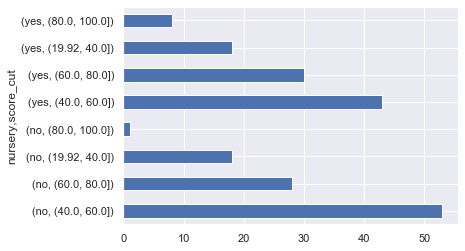

In [159]:
make_plot('nursery')

Из графика видно, что те, кто посещал детский сад в среднем намного чаще получают высокие оценки по математике.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Хочет ли ученик получить высшее образование**

**Анализ пропущенных значений:**

In [160]:
remove_na('higher')

There were 19 missings that have been removed


**Анализ значений переменной:**

In [161]:
get_stats(new_df['higher'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      higher
yes     320
no       13 
Additional info:


,Statistic,Value
0,count,333
1,unique,2
2,top,yes
3,freq,320


Почти все ученики хотят получать высшее образование в будущем.

**Подготовка данных и визуализация взаимосвязи:**

In [162]:
get_table('higher')

perc
higher score_cut          
no     (40.0, 60.0]   62.0
       (19.92, 40.0]  31.0
       (60.0, 80.0]    8.0
yes    (40.0, 60.0]   44.0
       (60.0, 80.0]   31.0
       (19.92, 40.0]  18.0
       (80.0, 100.0]   8.0

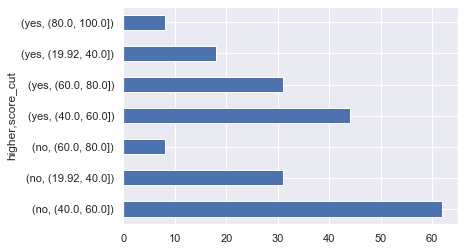

In [163]:
make_plot('higher')

Из графика видно, что не желающие получать высшее образование ученики не набирают наивысших баллов по математике. Вероятнее всего из-за отсутствия достаточной мотивации. В остальном, последние также показывают худшие результаты в касательно других категорий оценок.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Наличие интернета дома**

**Анализ пропущенных значений:**

In [164]:
remove_na('internet')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [165]:
get_stats(new_df['internet'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      internet
yes       274
no         49 
Additional info:


,Statistic,Value
0,count,323
1,unique,2
2,top,yes
3,freq,274


Около 15% учеников не имеют доступ в Интернет из дома.

**Подготовка данных и визуализация взаимосвязи:**

In [166]:
get_table('internet')

perc
internet score_cut          
no       (40.0, 60.0]   57.0
         (60.0, 80.0]   20.0
         (19.92, 40.0]  16.0
         (80.0, 100.0]   6.0
yes      (40.0, 60.0]   43.0
         (60.0, 80.0]   32.0
         (19.92, 40.0]  18.0
         (80.0, 100.0]   7.0

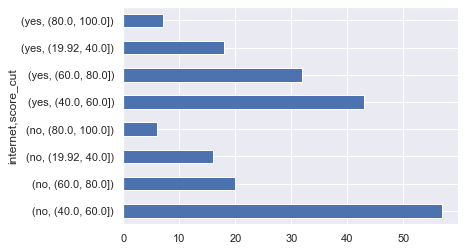

In [167]:
make_plot('internet')

Из графика видно, что доступ в интернет из дома в среднем положительно влияет на успеваемость по математике.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Состоит ли ученик в романтических отношениях**

**Анализ пропущенных значений:**

In [168]:
remove_na('romantic')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [169]:
get_stats(new_df['romantic'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      romantic
no        219
yes       104 
Additional info:


,Statistic,Value
0,count,323
1,unique,2
2,top,no
3,freq,219


Около 1/3 учеников состоят в романтических отношениях.

**Подготовка данных и визуализация взаимосвязи:**

In [170]:
get_table('romantic')

perc
romantic score_cut          
no       (40.0, 60.0]   44.0
         (60.0, 80.0]   29.0
         (19.92, 40.0]  17.0
         (80.0, 100.0]  10.0
yes      (40.0, 60.0]   46.0
         (60.0, 80.0]   34.0
         (19.92, 40.0]  18.0
         (80.0, 100.0]   2.0

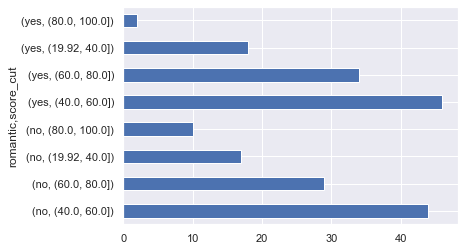

In [171]:
make_plot('romantic')

Из графика видно, что ученике, не состоящие в романтических отношениях в среднем намного чаще получают наивысшие оценки по математике, по сравнению с тем, кто состоит в отношениях.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Cемейные отношения**

**Анализ пропущенных значений:**

In [172]:
remove_na('famrel')

There were 24 missings that have been removed


**Анализ значений переменной:**

In [173]:
new_df.famrel = new_df.famrel.astype('str')
get_stats(new_df['famrel'])

There are 6 unique values in this variable: ['4.0' '5.0' '3.0' '-1.0' '2.0' '1.0'] 
Counts:       famrel
4.0      163
5.0       88
3.0       56
2.0       14
1.0        6
-1.0       1 
Additional info:


,Statistic,Value
0,count,328
1,unique,6
2,top,4.0
3,freq,163


В данных видна опечатка, исправим ее:

In [174]:
new_df['famrel'] = new_df['famrel'].replace(['-1.0'],'1.0')

In [175]:
get_stats(new_df['famrel'])

There are 5 unique values in this variable: ['4.0' '5.0' '3.0' '1.0' '2.0'] 
Counts:      famrel
4.0     163
5.0      88
3.0      56
2.0      14
1.0       7 
Additional info:


,Statistic,Value
0,count,328
1,unique,5
2,top,4.0
3,freq,163


В диапазоне от 1 - очень плохие и 5 - очень хорошие, большинство учеников оценивают отношения в семье как почти очень хорошие.

**Подготовка данных и визуализация взаимосвязи:**

In [176]:
get_table('famrel')

perc
famrel score_cut          
1.0    (40.0, 60.0]   43.0
       (60.0, 80.0]   43.0
       (19.92, 40.0]  14.0
2.0    (40.0, 60.0]   36.0
       (60.0, 80.0]   36.0
       (19.92, 40.0]  21.0
       (80.0, 100.0]   7.0
3.0    (40.0, 60.0]   50.0
       (60.0, 80.0]   29.0
       (19.92, 40.0]  14.0
       (80.0, 100.0]   7.0
4.0    (40.0, 60.0]   47.0
       (60.0, 80.0]   27.0
       (19.92, 40.0]  21.0
       (80.0, 100.0]   6.0
5.0    (40.0, 60.0]   42.0
       (60.0, 80.0]   33.0
       (19.92, 40.0]  15.0
       (80.0, 100.0]  10.0

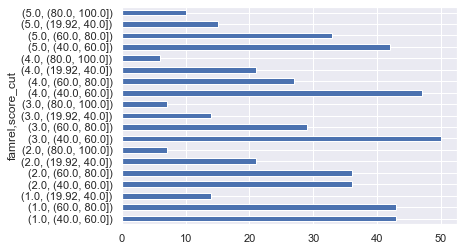

In [177]:
make_plot('famrel')

Из графика видно, что чем лучше отношения в семье (5), тем выше успеваемость по математике в среднем.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Cвободное время после школы**

**Анализ пропущенных значений:**

In [178]:
remove_na('freetime')

There were 8 missings that have been removed


**Анализ значений переменной:**

In [179]:
new_df.freetime = new_df.freetime.astype('str')
get_stats(new_df['freetime'])

There are 5 unique values in this variable: ['3.0' '2.0' '4.0' '1.0' '5.0'] 
Counts:      freetime
3.0       132
4.0       102
2.0        59
5.0        35
1.0        16 
Additional info:


,Statistic,Value
0,count,344
1,unique,5
2,top,3.0
3,freq,132


В диапазоне от 1 - очень мало и 5 - очень много, большинство учеников оценивают количество своего свободного времени как "среднее", однако также есть достаточно людей, у кого много свободного времени.

**Подготовка данных и визуализация взаимосвязи:**

In [180]:
get_table('freetime')

perc
freetime score_cut          
1.0      (40.0, 60.0]   50.0
         (19.92, 40.0]  25.0
         (60.0, 80.0]   12.0
         (80.0, 100.0]  12.0
2.0      (40.0, 60.0]   46.0
         (60.0, 80.0]   36.0
         (19.92, 40.0]  10.0
         (80.0, 100.0]   8.0
3.0      (40.0, 60.0]   47.0
         (60.0, 80.0]   30.0
         (19.92, 40.0]  18.0
         (80.0, 100.0]   5.0
4.0      (40.0, 60.0]   42.0
         (60.0, 80.0]   31.0
         (19.92, 40.0]  22.0
         (80.0, 100.0]   5.0
5.0      (40.0, 60.0]   46.0
         (60.0, 80.0]   23.0
         (19.92, 40.0]  17.0
         (80.0, 100.0]  14.0

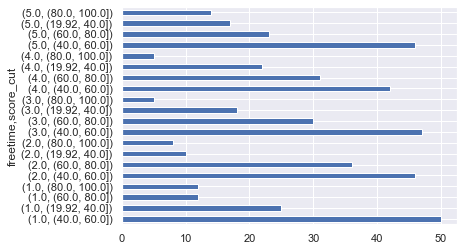

In [181]:
make_plot('freetime')

По графику можно отследить довольно странную взаимосвязь: довольно большой процент учеников получают наивысшие баллы по математике в категории "очень много свободного времени - 5" и в категории "очень мало сфободного времени - 1". Сложно однозначно интерпретировать данную ситуацию.

Таким образом, переменную скорее не стоит оставить для добавления в финальную модель в качестве предиктора.

### **Проведение времени с друзьями**

**Анализ пропущенных значений:**

In [182]:
remove_na('goout')

There were 6 missings that have been removed


**Анализ значений переменной:**

In [183]:
new_df.goout = new_df.goout.astype('str')
get_stats(new_df['goout'])

There are 5 unique values in this variable: ['4.0' '3.0' '2.0' '1.0' '5.0'] 
Counts:      goout
3.0    118
2.0     92
4.0     74
5.0     43
1.0     19 
Additional info:


,Statistic,Value
0,count,346
1,unique,5
2,top,3.0
3,freq,118


В диапазоне от 1 - очень мало и 5 - очень много, большинство учеников оценивают количество проводимого времени с друзьями как "среднее", однако ученики скорее склонны проводить не так много времени с друзьями в среднем.

**Подготовка данных и визуализация взаимосвязи:**

In [184]:
get_table('goout')

perc
goout score_cut          
1.0   (40.0, 60.0]   58.0
      (60.0, 80.0]   26.0
      (80.0, 100.0]  11.0
      (19.92, 40.0]   5.0
2.0   (40.0, 60.0]   47.0
      (60.0, 80.0]   36.0
      (19.92, 40.0]  10.0
      (80.0, 100.0]   8.0
3.0   (40.0, 60.0]   45.0
      (60.0, 80.0]   33.0
      (19.92, 40.0]  14.0
      (80.0, 100.0]   8.0
4.0   (40.0, 60.0]   39.0
      (19.92, 40.0]  28.0
      (60.0, 80.0]   28.0
      (80.0, 100.0]   4.0
5.0   (40.0, 60.0]   44.0
      (19.92, 40.0]  30.0
      (60.0, 80.0]   19.0
      (80.0, 100.0]   7.0

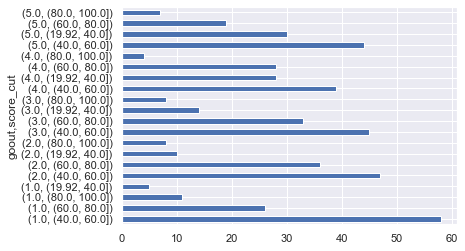

In [185]:
make_plot('goout')

Из графика видно, что умеренное количество времени, проводимое с друзьми, способствует в среднем лучшим результатам по математике (категории 2-3). Однако ученикик, которые довольно редко видяться с друзьми также показывают высокие результаты.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Текущее состояние здоровья**

**Анализ пропущенных значений:**

In [186]:
remove_na('health')

There were 13 missings that have been removed


**Анализ значений переменной:**

In [187]:
new_df.health = new_df.health.astype('str')
get_stats(new_df['health'])

There are 5 unique values in this variable: ['3.0' '5.0' '1.0' '2.0' '4.0'] 
Counts:      health
5.0     124
3.0      81
4.0      53
1.0      45
2.0      36 
Additional info:


,Statistic,Value
0,count,339
1,unique,5
2,top,5.0
3,freq,124


В диапазоне от 1 - очень плохое и 5 - очень хорошее, большинство учеников оценивают свое здоровье как "очень хорошее", и в среднем ученики склонны оценивать свое здоровье положительно.

**Подготовка данных и визуализация взаимосвязи:**

In [188]:
get_table('health')

perc
health score_cut          
1.0    (60.0, 80.0]   40.0
       (40.0, 60.0]   31.0
       (19.92, 40.0]  16.0
       (80.0, 100.0]  13.0
2.0    (40.0, 60.0]   39.0
       (60.0, 80.0]   39.0
       (19.92, 40.0]  11.0
       (80.0, 100.0]  11.0
3.0    (40.0, 60.0]   56.0
       (60.0, 80.0]   21.0
       (19.92, 40.0]  20.0
       (80.0, 100.0]   4.0
4.0    (40.0, 60.0]   45.0
       (60.0, 80.0]   26.0
       (19.92, 40.0]  19.0
       (80.0, 100.0]   9.0
5.0    (40.0, 60.0]   44.0
       (60.0, 80.0]   33.0
       (19.92, 40.0]  19.0
       (80.0, 100.0]   5.0

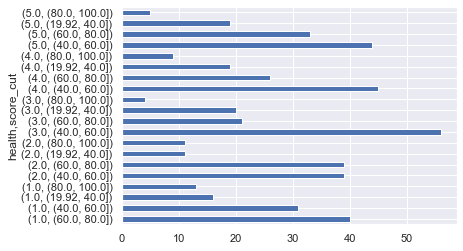

In [189]:
make_plot('health')

Из графика видно, что ученики с плохим состоянием здоровья учаться лучше, что довольно контеринтуитивно в данном случае.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Количество пропущенных занятий**

**Анализ пропущенных значений:**

In [207]:
remove_na('absences')

There were 10 missings that have been removed


**Анализ значений переменной:**

In [208]:
new_df.absences = new_df.absences.astype('int')
get_stats(new_df['absences'])

There are 36 unique values in this variable: [  6   4  10   2   0  16  14   7   8  25  12  54  18  26  20  56  24  28
   5  13  15  22   3 385  21   1  75  30  19   9  11  38  40  23  17 212] 
Counts:      absences
0          74
2          60
4          52
6          30
8          20
10         17
14         12
12         12
16          7
3           7
7           6
5           5
18          5
20          4
22          3
1           3
9           3
15          2
11          2
13          2
385         1
212         1
19          1
21          1
23          1
24          1
25          1
26          1
28          1
30          1
38          1
40          1
54          1
56          1
75          1
17          1 
Additional info:


,Statistic,Value
0,count,342.0
1,mean,8.1
2,std,24.7
3,min,0.0
4,25%,2.0
5,50%,4.0
6,75%,8.0
7,max,385.0


В среднем ученики пропускали от 2 до 8 занятий, что соответствует межкваритильному размаху, однако есть и те, кто не пропускал совсем, а также же, кто пропустил очень много. 

Посмотрим на выбросы. Верхняя граница пропусков - 17, соответственно удалим наблюдения в датасете показывают крайне нетипичное количество пропусков занятий.

In [211]:
check_outliers(new_df['absences'])

,lower_bound,upper_bound
0,-7.0,17.0


In [212]:
new_df = new_df[new_df.absences<18]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


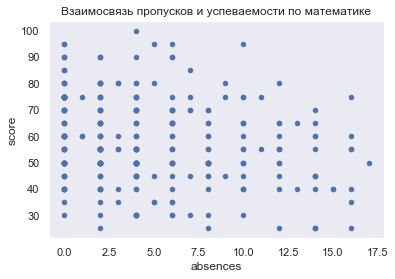

In [213]:
new_df.plot(x = 'absences', 
        y = 'score', 
        kind = 'scatter', 
        grid = False,
        title = 'Взаимосвязь пропусков и успеваемости по математике')

Никакой взаимосвязи между количеством пропусков и баллами по математике выявить не удалось.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Вывод**

В ходе эксплораторного анализа были выявлены следующие предикторы, которые при первичном обследовании оказались взаимосвязаны с зависимой переменной "былл по математике" и потенциально могут быть включены в финальную предсказательную модель:

* Пол ученика
* Тип жилой местности
* Статус сожительства родителей
* Образование матери
* Образование отца
* Работа матери
* Работа отца
* Время, затрачиваемое на учебу вне школы
* Посещение внеучебных занятий 
* Факт посещения десткого сада в прошлом
* Желание получить высшее образование
* Доступ в интернет
* Наличае романтических отношений
* Благополучность отношений в семье
* Количество времени, проводимое с друзьями